## Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import *
from prettytable import PrettyTable
from wordcloud import WordCloud

## Load preprocessed data 

In [3]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp

y_train =openfromfile('y_train')
y_test =openfromfile('y_test')

count_vect =openfromfile('count_vect')
X_train_bigram = openfromfile('X_train_bigram')
X_test_bigram = openfromfile('X_test_bigram')

tf_idf_vect =openfromfile('tf_idf_vect')
X_train_tfidf =openfromfile('X_train_tfidf')
X_test_tfidf =openfromfile('X_test_tfidf')

avg_sent_vectors=openfromfile('avg_sent_vectors')
avg_sent_vectors_test=openfromfile('avg_sent_vectors_test')

tfidf_sent_vectors=openfromfile('tfidf_sent_vectors')
tfidf_sent_vectors_test=openfromfile('tfidf_sent_vectors_test')


## Standardizing data

In [4]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

# Logistic Regression

### Function for finding optimal value of hyperparameter nd draw error plot :

In [13]:
def LR_Classifier(x_train,y_train,TBS,params,penalty,searchMethod,vect):
    ''' FUNCTION FOR FINDING OPTIMAL VALUE OF HYPERPARAM AND DRAW ERROR PLOT '''
    #INITIALIZE LOGISTIC REGRESSION OBJECT
    clf=LogisticRegression(penalty=penalty,class_weight='balanced',random_state=1)
    
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='grid':
        model=GridSearchCV(clf,\
                           cv=TBS,\
                           n_jobs=-1,\
                           param_grid=params,\
                           return_train_score=True,\
                           scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    elif searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 n_jobs=-1,\
                                 cv=TBS,\
                                 param_distributions=params,\
                                 n_iter=len(params['C']),\
                                 return_train_score=True,\
                                 scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    
    #PLOT HYPERPARAM VS AUC VALUES(FOR BOTH CV AND TRAIN)     
    train_auc= model.cv_results_['mean_train_score']
    train_auc_std= model.cv_results_['std_train_score']
    cv_auc = model.cv_results_['mean_test_score'] 
    cv_auc_std= model.cv_results_['std_test_score']

    plt.plot(params['C'], train_auc, label='Train AUC')
    # Reference Link: https://stackoverflow.com/a/48803361/4084039
    # gca(): get current axis
    plt.gca().fill_between(params['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    plt.plot(params['C'], cv_auc, label='CV AUC')
    # Reference Link: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(params['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    
    plt.title('ERROR PLOT (%s)' %vect)
    plt.xlabel('C(1/lambda): Hyperparam')
    plt.ylabel('AUC')
    plt.grid(True)
    plt.legend()
    plt.show()
    return model
        

### Function which calculate performance on test data with optimal hyperparam : 

In [6]:
def test_performance(x_train,y_train,x_test,y_test,optimal_c,penalty,vect,summarize):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL_K'''
    #INITIALIZE LR OBJECT WITH OPTIMAL HYPERPARAM
    clf=LogisticRegression(class_weight='balanced',penalty=penalty,C=optimal_c,n_jobs=-1)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    test_probability = clf.predict_proba(x_test)[:,1]
    train_probability = clf.predict_proba(x_train)[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, test_probability,pos_label=1)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, train_probability,pos_label=1)
    auc_score_test=auc(fpr_test, tpr_test)
    auc_score_train=auc(fpr_train, tpr_train)
    f1=f1_score(y_test,y_pred,average='weighted')
    #ADD RESULTS TO PRETTY TABLE
    summarize.add_row([vect, penalty, optimal_c, '%.3f' %auc_score_test,'%.3f' %f1])
    
    plt.figure(1,figsize=(14,5))
    plt.subplot(121)
    plt.title('ROC Curve (%s)' %vect)
    #IDEAL ROC CURVE
    plt.plot([0,1],[0,1],'k--')
    #ROC CURVE OF TEST DATA
    plt.plot(fpr_test, tpr_test , 'b', label='Test_AUC= %.2f' %auc_score_test)
    #ROC CURVE OF TRAIN DATA
    plt.plot(fpr_train, tpr_train , 'g', label='Train_AUC= %.2f' %auc_score_train)
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc='lower right')
    #PLOT CONFUSION MATRIX USING HEATMAP
    plt.subplot(122)
    plt.title('Confusion-Matrix(Test Data)')
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ['Negative','Positive'],['Negative','Positive'])
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm,cmap='gist_earth', annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()
    return clf

### Function for sparisty check:

In [7]:
def check_sparsity(x_train,x_test,y_train,y_test,c_vals):
    print('change in sparsity with increase in lambda(1/C) :\n')
    for c in c_vals:
        lr=LogisticRegression(penalty='l1',C=c,class_weight='balanced')
        lr.fit(x_train,y_train)
        pred=lr.predict(x_test)
        print('features having non-zero weights {0} when c={1}\n'.format(np.count_nonzero(lr.coef_), c))

### Function for perturbation test to check multicollinearity

In [29]:
def pertubation_test(x_train,x_test,y_train,y_test,optimal_c):
    
    fetures_wt_change=[]
    #MODEL BEFORE NOISE
    clf_before = LogisticRegression(penalty='l2',C=optimal_c,class_weight='balanced',random_state=1)
    clf_before.fit(x_train, y_train)
    
    # ADD A SMALL NOISE TO DATA
    x_train.data += .001
     
    #MODEL AFTER NOISE    
    clf_after= LogisticRegression(penalty='l2',C=optimal_c,class_weight='balanced',random_state=1)
    clf_after.fit(x_train, y_train)
    
    w_before=find(clf_before.coef_[0])[2]
    w_after=find(clf_after.coef_[0])[2]
    
    #ADD ERROR TO GET RID OFF DIVISION BY ZERO ERROR
    error=.000001#np.random.normal(.000005,.001)#np.random.normal(.000005,.000001,1)
    w_before += error
    w_after += error
    print('size of w_before_noise:',w_before.size)
    print('size of w_after_noise:',w_after.size)
    
    #PERCENTAGE CHANGE IN WEIGHT CORRESPONDS TO EACH FEATURE
    percentage_change = np.array((abs(w_before-w_after)/w_before )* 100)
    print('shape of percentage change:',percentage_change.shape)
    if len(w_before)==len(w_after):
        thresholds=[10,20,30,50,70,90,100]
        for threshold in thresholds:
            fetures_wt_change.append(percentage_change[np.where(percentage_change > threshold)].size)
    plt.figure(1,figsize=(12,6))    
    plt.plot(thresholds,fetures_wt_change)
    for xy in zip(thresholds,fetures_wt_change):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.xlabel('Threshold values')
    plt.ylabel('no. of collinear features')
    plt.title('Elbow Method(Multicollinearity Check)')
    plt.grid(True)
    plt.show()
    return percentage_change
   

### Function which plots collinear features using wordcloud :

In [9]:
def print_multicollinear_features(percentage_change,threshold,vect):
    feat=vect.get_feature_names()
    collinear_features=[]
    collinear_features_no=percentage_change[np.where(percentage_change > threshold)].size
    index=np.where(percentage_change > threshold)[0]
    for i in index:
        collinear_features.append(feat[i])
    print(collinear_features_no)
    if len(collinear_features)!=0:
        #wordcloud plot
        wordcloud = WordCloud(max_font_size=50, max_words=100,collocations=False).\
        generate(str(collinear_features))
        plt.figure(1,figsize=(14,13))
        plt.title("WordCloud(Collinear-Features)")
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    

### Function which print top important fetures and plot them using Bar plot :

In [10]:
#REFERENCE STACKOVERFLOW
def feature_importance(vectorizer,clf,n):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\tNegative\t\t\t\t\tPositive\t\t")
    print("_"*75)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    
    coef=sorted(clf.coef_[0],reverse=True)
    #STORE WEIGHT CORRESPONDING TO TOP POSITIVE AND NEGATIVE IMPORTANT FEATURES
    coef_p=coef[:n]
    coef_n=coef[:-(n + 1):-1]
    coef_np=coef_n+coef_p
    indices_n=np.argsort(clf.coef_[0])[:n]
    indices_p=np.argsort(clf.coef_[0])[::-1][:n]
    indices=list(indices_n)+list(indices_p)
    names = np.array(vectorizer.get_feature_names())
    #bar chart 
    plt.figure(2,figsize=(13,6))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    # Create plot title
    plt.title("Feature Importance(top %d positive and negative class features)" % n)
    # Add bars
    plt.bar(range(2*n), coef_np)
    # Add feature names as x-axis labels
    plt.xticks(range(2*n), names[indices], rotation=80)
    plt.show()

### Initialization of common objects required for all vectorization:

In [11]:
#VECTORIZER
vect=['BoW','TF-IDF','AVG-W2V','TFIDF-W2V']
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=10)
#METHOD USE FOR HYPER PARAMETER TUNNING
searchMethod='random'
#RANGE OF K VALUES(HYPERPARAM)
c_ranges=[1000,500,100,50,10,5,1,.5,.1,.05,.01,.005,.001,.0005,.0001]
params={'C':c_ranges}
#REGULARIZER USED
penalty=['l1','l2']
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Regularizer', 'Optimal-C(1/lambda)', 'Test(AUC)','Test(f1-score)']

###  [1.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

#### [1.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

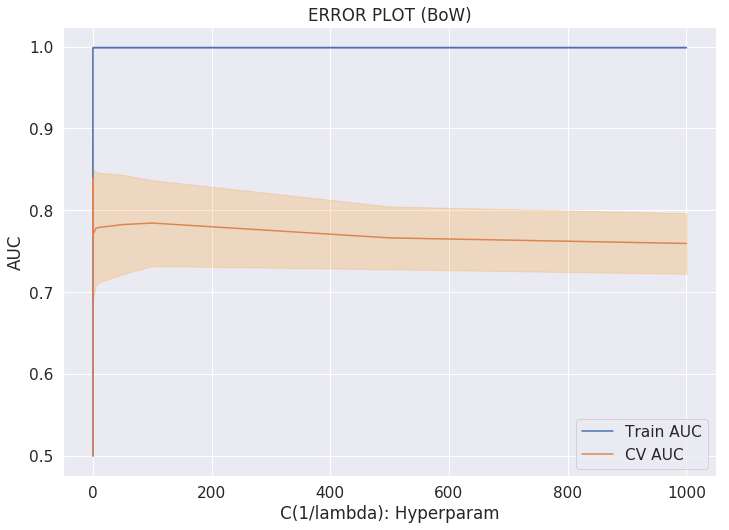

CPU times: user 14.9 s, sys: 428 ms, total: 15.3 s
Wall time: 17.3 s
Optimal value of C(1/lambda):  {'C': 0.005}


In [46]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[0],searchMethod,vect[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [1.1.1.1] Performance on test data with optimal value of hyperparam

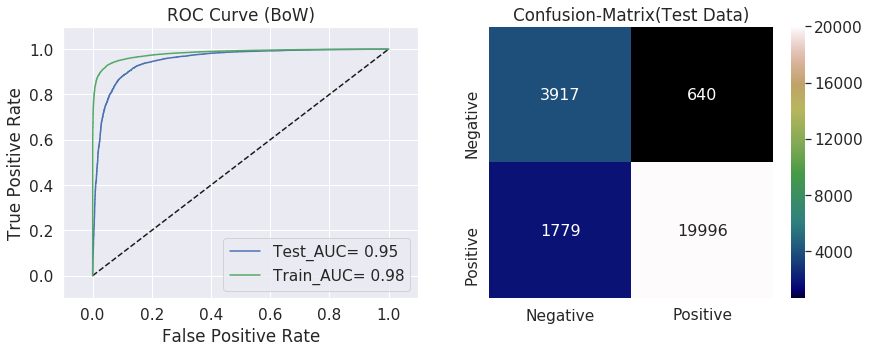

In [47]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[0],vect[0],summarize)

#### [1.1.1.2] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [16]:
check_sparsity(train,test,y_train,y_test,params['C'])

change in sparsity with increase in lambda(1/C) :

features having non-zero weights 58396 when c=1000

features having non-zero weights 63177 when c=500

features having non-zero weights 24507 when c=100

features having non-zero weights 27508 when c=50

features having non-zero weights 19136 when c=10

features having non-zero weights 16760 when c=5

features having non-zero weights 14097 when c=1

features having non-zero weights 13286 when c=0.5

features having non-zero weights 11789 when c=0.1

features having non-zero weights 10748 when c=0.05

features having non-zero weights 5676 when c=0.01

features having non-zero weights 2907 when c=0.005

features having non-zero weights 172 when c=0.001

features having non-zero weights 54 when c=0.0005

features having non-zero weights 0 when c=0.0001



### Observation:
1. From the above analysis we can observe that as the value of lambda(1/C) increases our weight vector becomes more sparse.
2. Weights corresponds to unimportant features or less important fetures becomes zero when we are using L1 regularizer.

#### [1.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

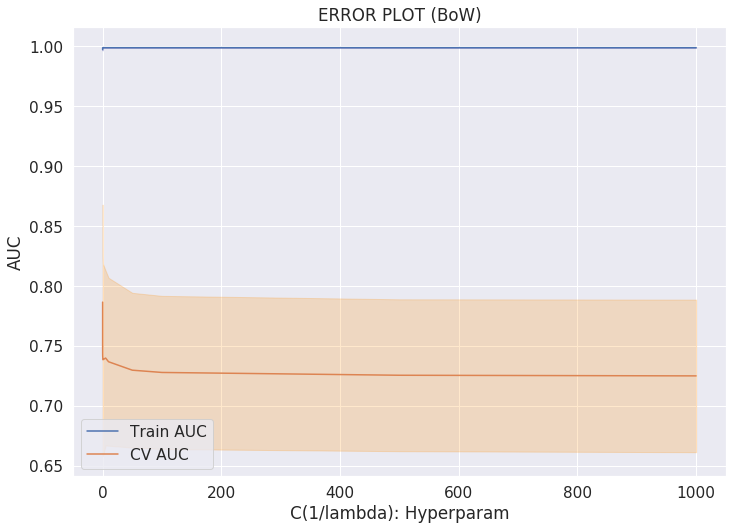

CPU times: user 42.6 s, sys: 1.03 s, total: 43.6 s
Wall time: 10min 25s
Optimal value of C(1/lambda):  {'C': 0.0001}


In [45]:
train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[1],searchMethod,vect[0])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [1.1.2.1] Performance on test data with optimal value of hyperparam

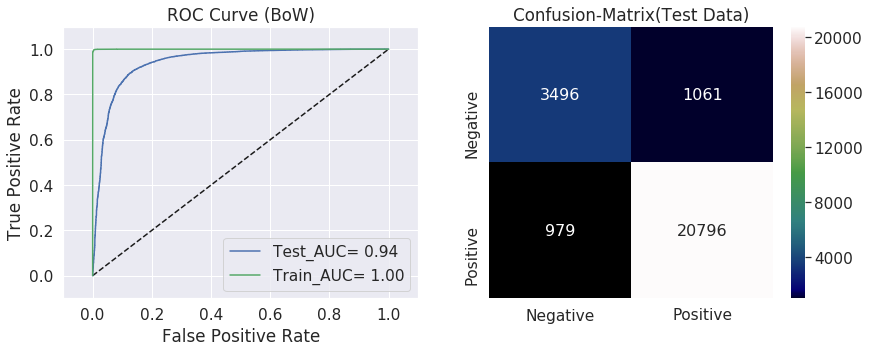

In [18]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[1],vect[0],summarize)

#### [1.1.2.2] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

size of w_before_noise: 83188
size of w_after_noise: 83188
shape of percentage change: (83188,)


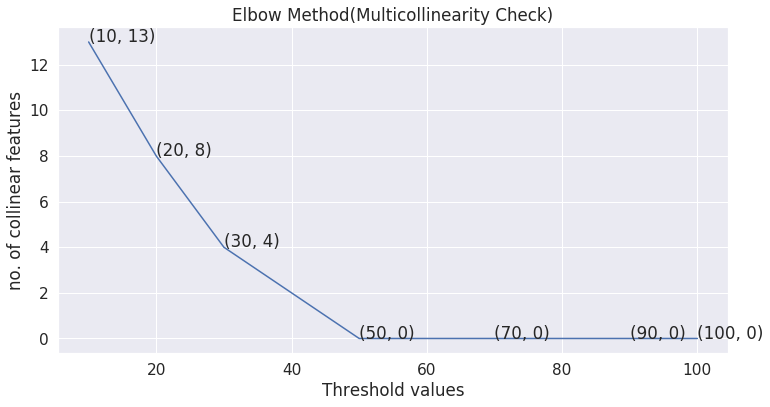

In [19]:
#train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
percentage_change=pertubation_test(train,test,y_train,y_test,model.best_params_['C'])

### Observation:
1. From the above plot we find that curve changes significantly at threshold value of 50(i.e. our knee point).
2. Number of fetures which have percentage weight change more than the threshold=50 are zero, so our features are independent.

#### [1.1.2.3] Print collinear features in word cloud

In [20]:
#SELECTED THRESHOLD BY USING ELBOW METHOD
threshold=50
print_multicollinear_features(percentage_change,threshold,count_vect)

0


#### [1.1.3] Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

	Negative					Positive		
___________________________________________________________________________
	-0.0707	disappoint     				0.1000	great          
	-0.0707	not buy        				0.0903	love           
	-0.0555	not worth      				0.0655	best           
	-0.0547	worst          				0.0611	delici         
	-0.0534	not recommend  				0.0598	good           
	-0.0509	not good       				0.0485	perfect        
	-0.0453	terribl        				0.0465	excel          
	-0.0441	not purchas    				0.0453	favorit        
	-0.0441	threw          				0.0427	nice           
	-0.0438	would not      				0.0426	high recommend 


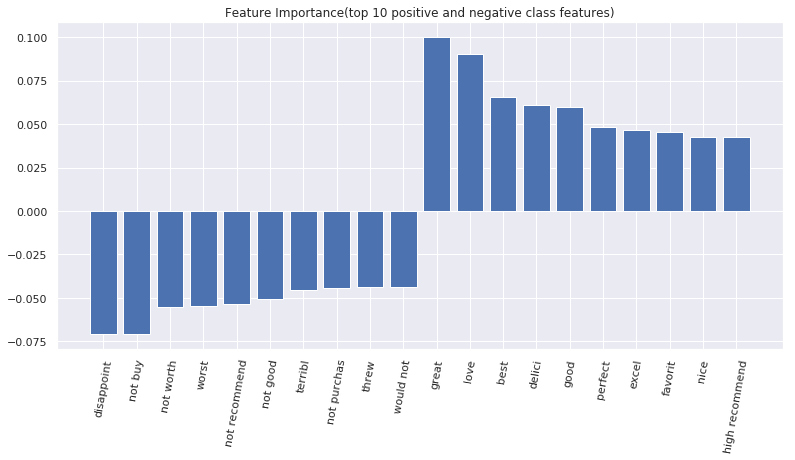

In [21]:
no_of_imp_features=10
feature_importance(count_vect,clf,no_of_imp_features)

### 2.1 Logistic Regression on TFIDF,<font color='red'> SET 2</font>

#### [2.1.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

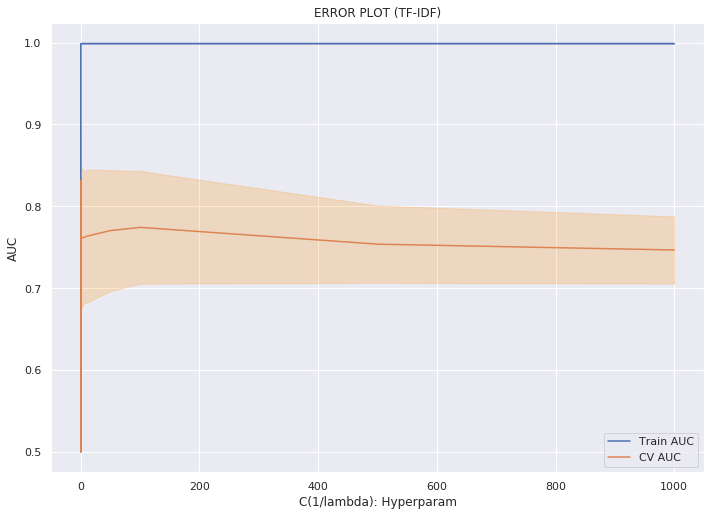

CPU times: user 15 s, sys: 348 ms, total: 15.3 s
Wall time: 17 s
Optimal value of C(1/lambda):  {'C': 0.005}


In [23]:
searchMethod='random'
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[0],searchMethod,vect[1])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [2.1.1.1] Performance on test data with optimal value of hyperparam

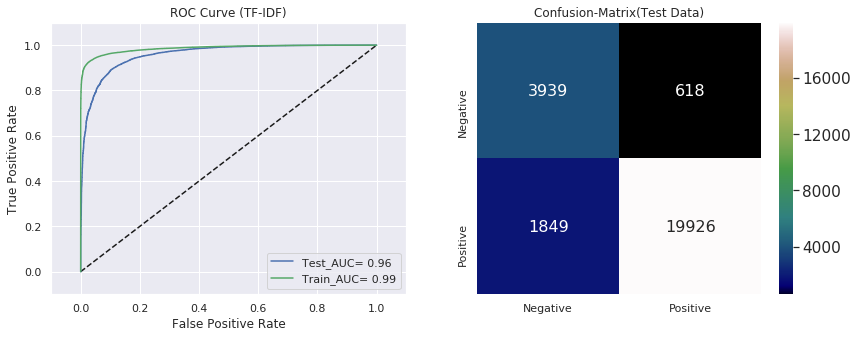

In [24]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[0],vect[1],summarize)

#### [2.1.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

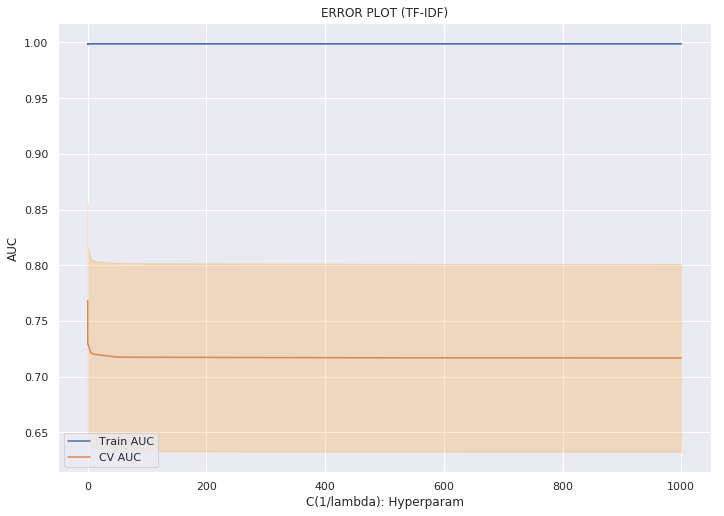

CPU times: user 31.8 s, sys: 608 ms, total: 32.4 s
Wall time: 4min 15s
Optimal value of C(1/lambda):  {'C': 0.0001}


In [26]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[1],searchMethod,vect[1])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [2.1.2.1] Performance on test data with optimal value of hyperparam

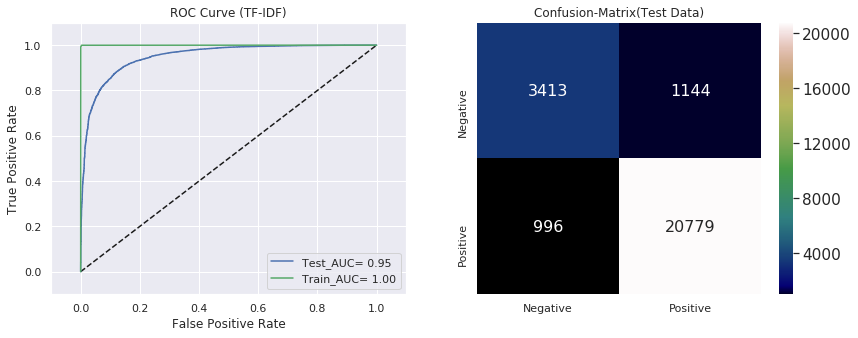

In [27]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[1],vect[1],summarize)

#### [2.1.3] Top 10 important features of positive and negative class from<font color='red'> SET 2</font>

	Negative					Positive		
___________________________________________________________________________
	-0.3347	disappoint     				0.6698	great          
	-0.2117	not            				0.4816	love           
	-0.1866	worst          				0.4169	best           
	-0.1677	not good       				0.4000	delici         
	-0.1633	not buy        				0.3954	good           
	-0.1508	not recommend  				0.3003	perfect        
	-0.1504	aw             				0.2732	excel          
	-0.1496	not worth      				0.2475	not disappoint 
	-0.1457	bad            				0.2348	nice           
	-0.1388	return         				0.2258	favorit        


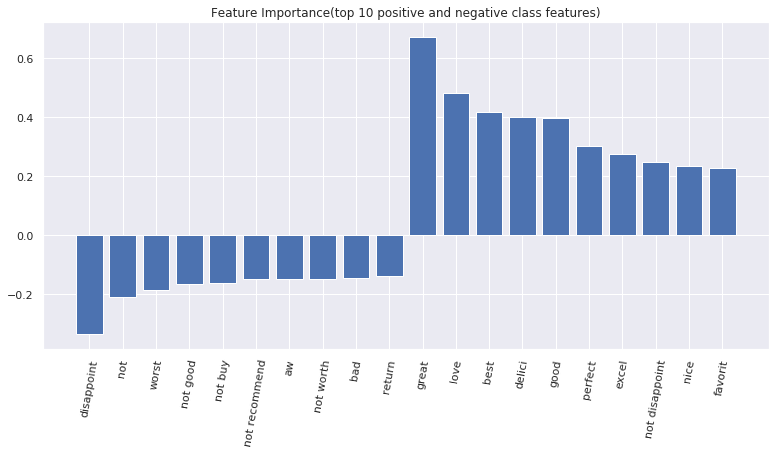

In [25]:
feature_importance(tf_idf_vect,clf,10)

#### [2.1.4] Performing pertubation test (multicollinearity check) on TFIDF,<font color='red'> SET 2</font>

size of w_before_noise: 83188
size of w_after_noise: 83188
shape of percentage change: (83188,)


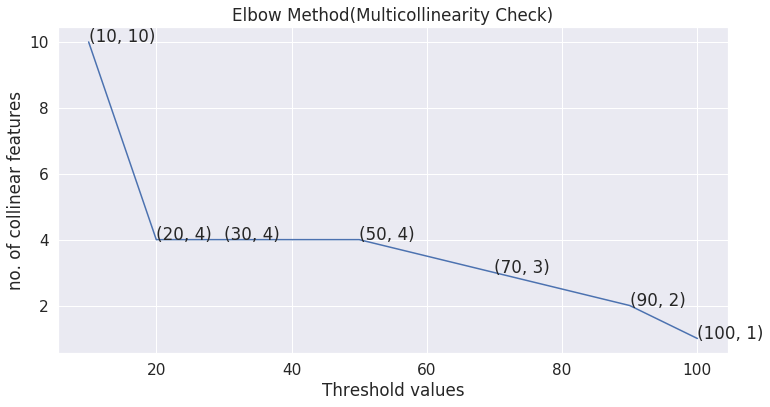

In [31]:
#train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
percentage_change=pertubation_test(train,test,y_train,y_test,model.best_params_['C'])

### Observation:
1. From the above plot we find that curve changes significantly at threshold value of 20(i.e. our knee point).
2. Number of fetures which have percentage weight change more than the threshold=20 are four, so our features are independent.

#### [2.1.4.1]Print collinear features in word cloud

4


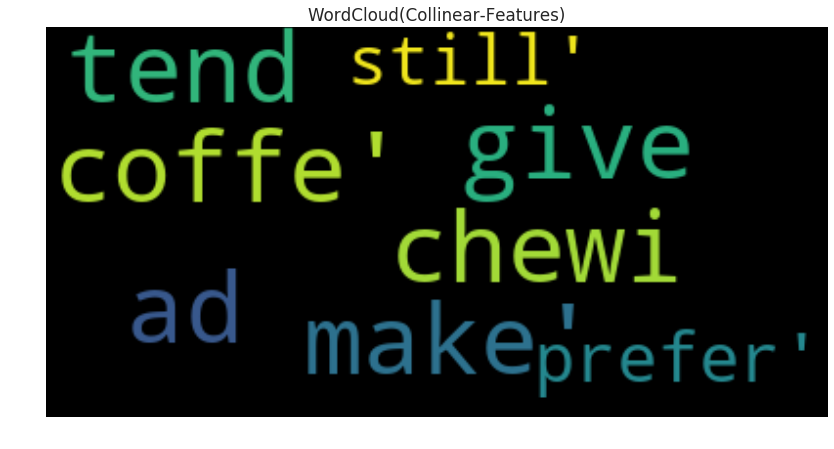

In [32]:
#SELECTED THRESHOLD BY USING ELBOW METHOD
threshold=20
print_multicollinear_features(percentage_change,threshold,count_vect)

### [3.1] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

#### [3.1.1] Applying Logistic Regression with L1 regularization on AVG W2V,<font color='red'> SET 3</font>

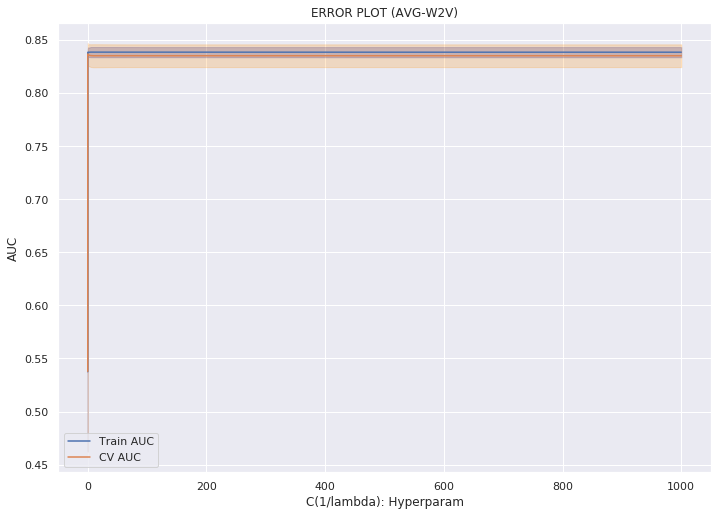

CPU times: user 21.1 s, sys: 464 ms, total: 21.5 s
Wall time: 38 s
Optimal value of C(1/lambda):  {'C': 0.05}


In [35]:
searchMethod='random'
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=avg_sent_vectors,test=avg_sent_vectors_test,mean=True)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[0],searchMethod,vect[2])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [3.1.1.1] Performance on test data with optimal value of hyperparam

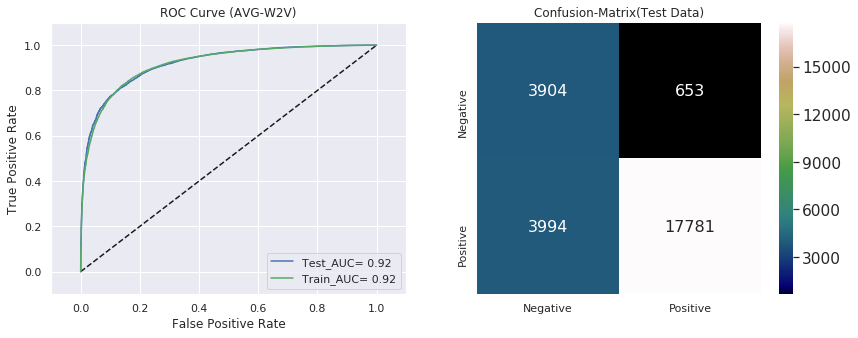

In [36]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[0],vect[2],summarize)

#### [3.1.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

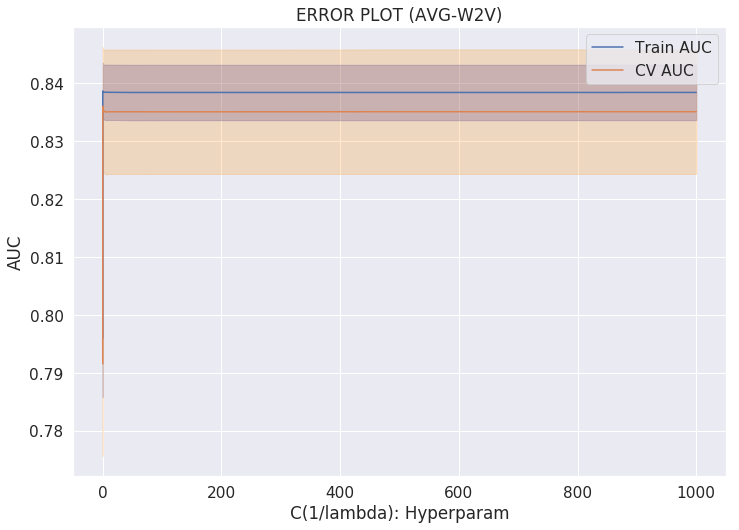

CPU times: user 20.5 s, sys: 328 ms, total: 20.8 s
Wall time: 36 s
Optimal value of C(1/lambda):  {'C': 0.05}


In [37]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=avg_sent_vectors,test=avg_sent_vectors_test,mean=True)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[1],searchMethod,vect[2])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [3.1.2.1] Performance on test data with optimal value of hyperparam

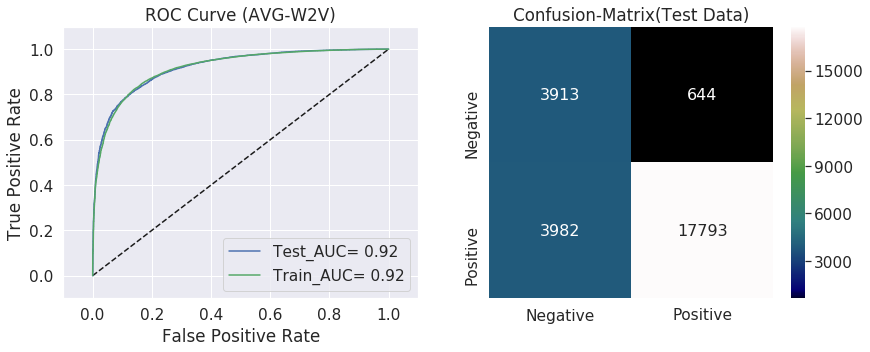

In [38]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[1],vect[2],summarize)

### [4.1] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

#### [4.1.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

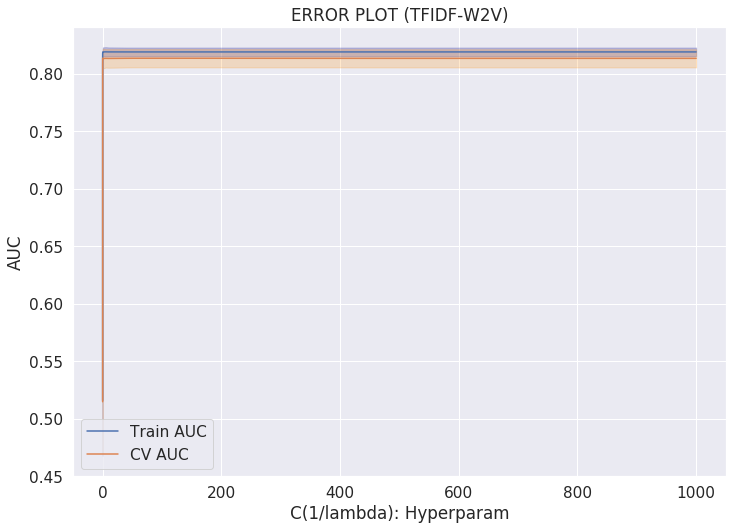

CPU times: user 22.8 s, sys: 460 ms, total: 23.3 s
Wall time: 49.8 s
Optimal value of C(1/lambda):  {'C': 0.1}


In [39]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=tfidf_sent_vectors,test=tfidf_sent_vectors_test,mean=True)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[0],searchMethod,vect[3])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [4.1.1.1] Performance on test data with optimal value of hyperparam

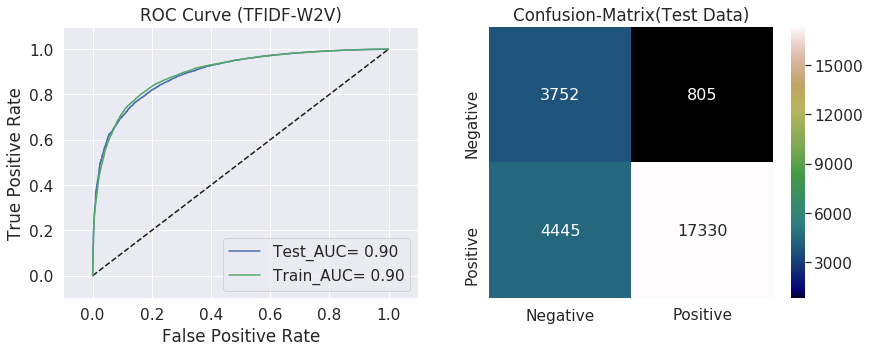

In [40]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[0],vect[3],summarize)

#### [4.1.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

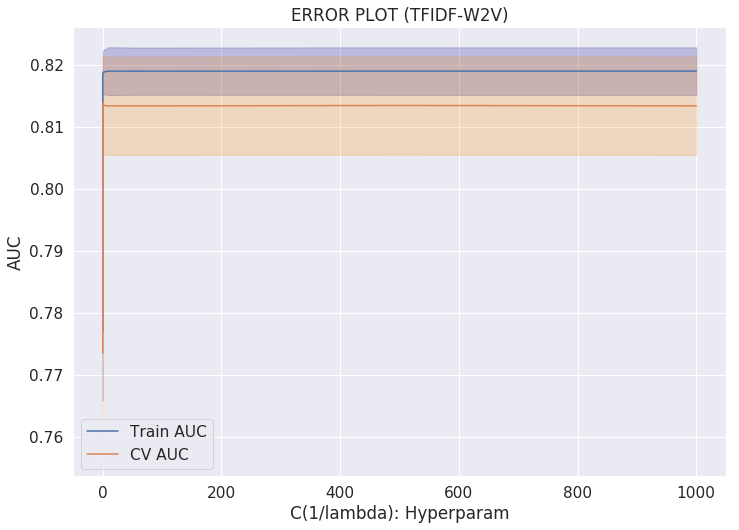

CPU times: user 21 s, sys: 364 ms, total: 21.4 s
Wall time: 37.8 s
Optimal value of C(1/lambda):  {'C': 0.1}


In [41]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=tfidf_sent_vectors,test=tfidf_sent_vectors_test,mean=True)
#HYPERPARAM TUNNING
%time model=LR_Classifier(train,y_train,TBS,params,penalty[1],searchMethod,vect[3])
print('Optimal value of C(1/lambda): ',model.best_params_)

#### [4.1.2.1] Performance on test data with optimal value of hyperparam

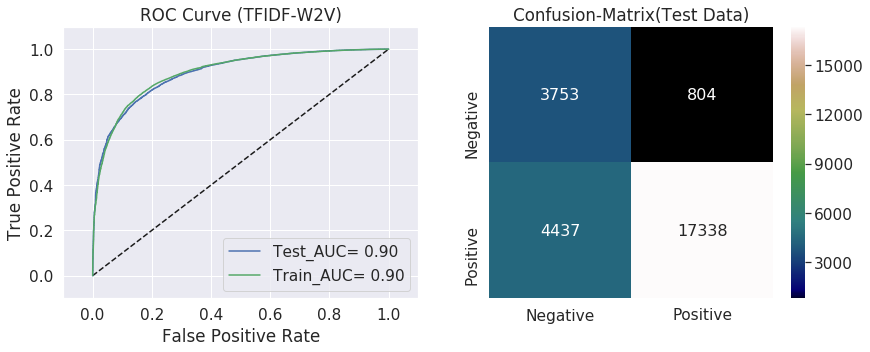

In [42]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['C'],penalty[1],vect[3],summarize)

## Conclusions:

In [44]:
print(summarize)

+------------+-------------+---------------------+-----------+----------------+
| Vectorizer | Regularizer | Optimal-C(1/lambda) | Test(AUC) | Test(f1-score) |
+------------+-------------+---------------------+-----------+----------------+
|    BoW     |      l1     |        0.005        |   0.952   |     0.912      |
|    BoW     |      l2     |        0.0001       |   0.942   |     0.922      |
|   TF-IDF   |      l1     |        0.005        |   0.959   |     0.911      |
|   TF-IDF   |      l2     |        0.0001       |   0.950   |     0.918      |
|  AVG-W2V   |      l1     |         0.05        |   0.919   |     0.840      |
|  AVG-W2V   |      l2     |         0.05        |   0.919   |     0.841      |
| TFIDF-W2V  |      l1     |         0.1         |   0.895   |     0.820      |
| TFIDF-W2V  |      l2     |         0.1         |   0.895   |     0.820      |
+------------+-------------+---------------------+-----------+----------------+


### 1. from the above table we can observe that the optimal performance is give by:
               a. TFIDF vectorizer
               b. f1-score=.911 and auc=.959